In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import json
import os
from scipy.optimize import minimize_scalar
from scipy import stats
import pandas as pd
import datetime
from probssm.ivp import sir_rhs
from statsmodels.tsa.stattools import grangercausalitytests, ccf

In [2]:
dir_list = [el for el in os.listdir() if el.startswith("run_can")]
dir_list.sort(key=lambda x: os.path.getmtime(x))
run = dir_list[-1]
print(dir_list)
print("plotting run : {}".format(run))

['run_can_2023-02-15_18-37-21']
plotting run : run_can_2023-02-15_18-37-21


In [3]:
arr = np.load(run + "/posterior_first.npz")
data = np.load(run + "/data_info.npz")
projections = np.load(run + "/projections.npz")
filter_info = np.load(run + "/filtering_info.npz", allow_pickle=True)["arr_0"]
with open(run + "/info.json") as f:
    info = json.load(f)

In [4]:
def beta_link_fn(x, info, data, y_offset=0.0):
    slope = info["sigmoid_slope"]
    x_offset = -scipy.special.logit(data["beta_prior_mean"])
    return scipy.special.expit(slope * (x - x_offset)) + y_offset

## Sanity Checks

In [5]:
logS = arr["means"][:, 0]
S = np.exp(logS)
logSp = arr["means"][:, 1]
Sp = S * logSp
logI = arr["means"][:, 3]
I = np.exp(logI)
logIp = arr["means"][:, 4]
Ip = I * logIp
logR = arr["means"][:, 6]
R = np.exp(logR)
logRp = arr["means"][:, 7]
Rp = R * logRp
beta = arr["means"][:, 9]
beta_link = beta_link_fn(beta, info, data)

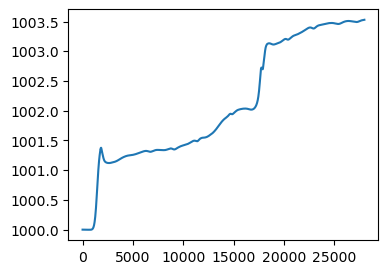

In [6]:
#Check that S + I + R = 1000 with small error (1e-2) due to diffusion noise
plt.figure(figsize=(4,3))
plt.plot(S + I + R)

In [7]:
np.mean(Rp/I), np.median(Rp/I), np.mean((Rp/I)[2500:])

(0.04315049313556485, 0.04509345534966023, 0.04493773188890558)

In [8]:
gamma = 0.049915
a = np.cov(Sp - -(S * I * beta_link/ 1000))
b = np.cov(Ip - (S * I * beta_link/ 1000 - gamma * I))
c = np.cov(Rp - gamma * I)
np.mean([a,b,c])

0.00017327320266297055

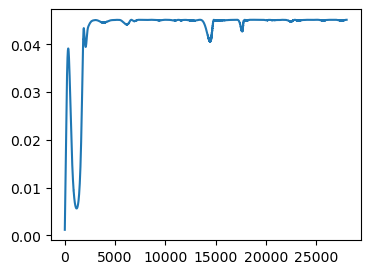

In [9]:
#Check that Rp = gamma * I, where gamma = 0.06
plt.figure(figsize=(4,3))
plt.plot(Rp / I)

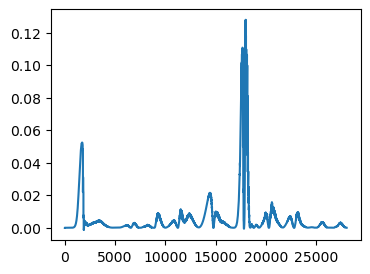

In [10]:
#Check that Sp = - S * I * beta / 1000
plt.figure(figsize=(4,3))
plt.plot(Sp + S * I * beta_link/ 1000)

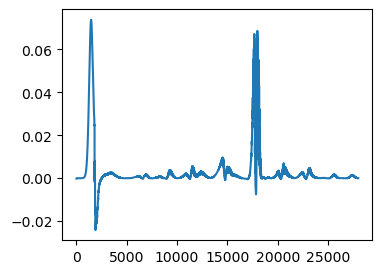

In [11]:
#Check that Ip + Sp + Rp = 0 (from Ip = -Sp - Rp)
plt.figure(figsize=(4,3))
plt.plot(Ip + Sp + Rp)

In [12]:
#Check if we are extracting the right indices when plotting. 
#If its a list of float int, we good
data["dense_grid"][::(1+int(1/info["filter_step_size"]))][:10]

array([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.])

## Plotting results

Skipping first 0 days...
Population size of 1000.0
Negligible error on case counts (<1)
Data Covariance : 1.0098897572165454e-08
ODE Covariance : 2.0345311243958814e-05
Diffusion intensity (beta) : 0.001
Diffusion intensity (x) : 0.01


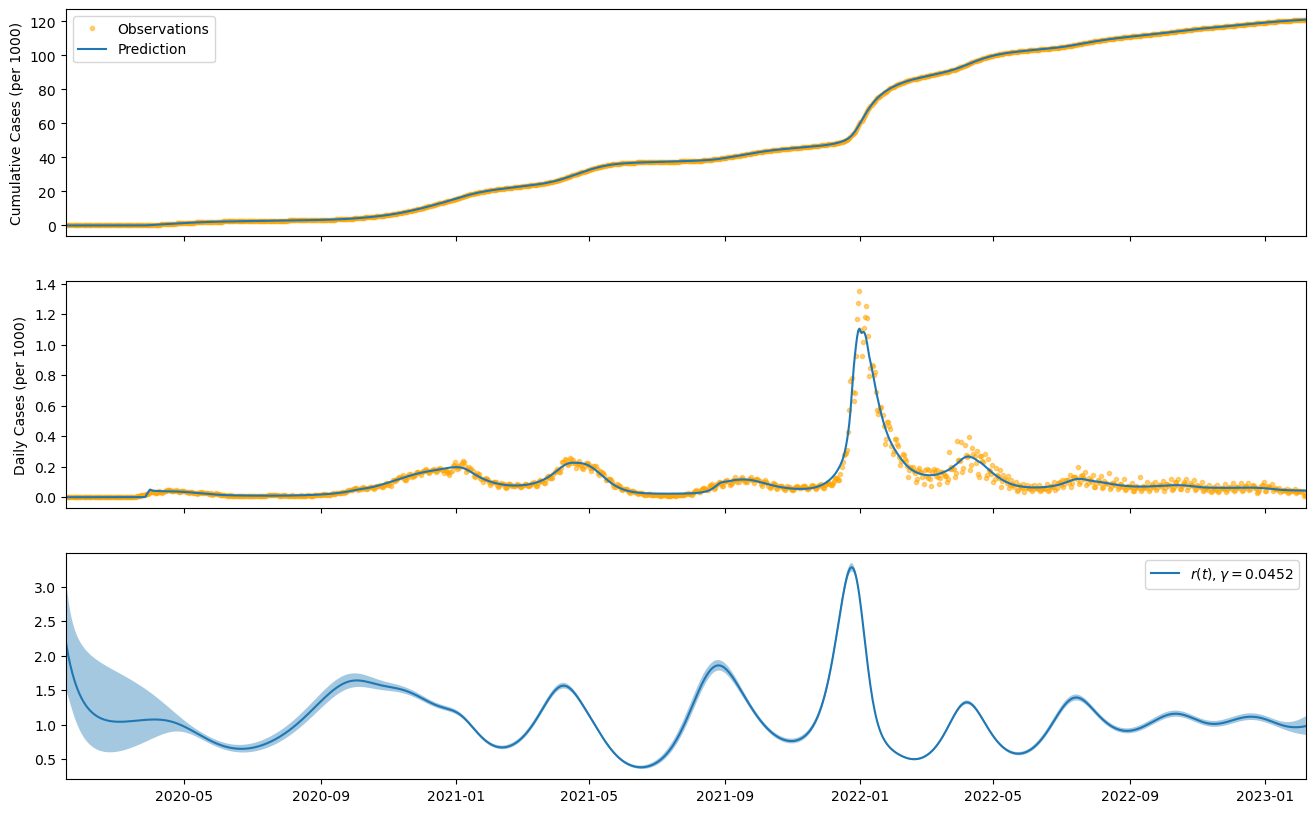

In [13]:
tmin_idx, tmax_idx = data["time_domain"].astype(int)
dates = data["date_range_x"][tmin_idx : tmax_idx]

N = 1000.0
skip_first_n_days = 0
print(f"Skipping first {skip_first_n_days} days...")
print(f"Population size of {N}")

#step is 1/filter_step_size
step = 1+int(1/info["filter_step_size"])

obs = pd.DataFrame({"daily": np.abs(np.diff(data["sir_data"][:, 0], prepend=data["sir_data"].max())),
              "cum" : N - data["sir_data"][:,0]},
              index = dates) 

#(log_S)' = (1/S) S'(t) -> S'(t) = S(t) * (log_S)'. Daily case count is -S'(t). Cum cases is N - S(t)
predicted_daily_cases = - (np.exp(arr["means"][:, 0]) * arr["means"][:,1])[::step] 
predicted_cum_cases = N - np.exp(arr["means"][:, 0])[::step]

# sigma_S = sigma_logS * d/dS (f(S)) = sigma_logS * exp(S)
pred_cum_err = 3 * (np.sqrt(arr["covs"][:, 0,0]) * np.exp(arr["means"][:, 0]))[::25]
if pred_cum_err.mean() < 1 : print("Negligible error on case counts (<1)")
    
r_t_high = beta_link_fn(arr["means"][:,-2][::step] + 3*np.sqrt(arr["covs"][::25, -2, -2]), info, data)/data["gamma"]
r_t_low = beta_link_fn(arr["means"][:,-2][::step] - 3*np.sqrt(arr["covs"][::25, -2, -2]), info, data)/data["gamma"]
r_t_mid = beta_link_fn(arr["means"][:,-2][::step], info, data)/data["gamma"]

fig,axs = plt.subplots(3, 1, figsize=(16,10), sharex=True)
axs[0].plot(obs.index, obs.cum, '.', color='orange', alpha=0.5, label="Observations")
axs[0].plot(obs.index, predicted_cum_cases, label="Prediction")
#axs[0].fill_between(obs.index, predicted_cum_cases - pred_cum_err, predicted_cum_cases + pred_cum_err, label="Predictions")
axs[0].set_ylabel("Cumulative Cases (per 1000)")
axs[0].legend()

axs[1].plot(obs.index, obs.daily, '.', color='orange', alpha=0.5)
axs[1].plot(obs.index, predicted_daily_cases)
axs[1].set_ylabel("Daily Cases (per 1000)")

axs[2].fill_between(obs.index[skip_first_n_days:], r_t_low[skip_first_n_days:], r_t_high[skip_first_n_days:], alpha = 0.4)
axs[2].plot(obs.index[skip_first_n_days:], r_t_mid[skip_first_n_days:], label=r"$r (t), \gamma = $" + "{:.4f}".format(data["gamma"]))
axs[2].legend()
axs[0].set_xlim(dates[skip_first_n_days], dates[-1]);

print("Data Covariance : {}".format(data["data_measurement_cov"]))
print("ODE Covariance : {}".format(data["ode_measurement_cov"]))
print("Diffusion intensity (beta) : {}".format(data["beta_process_diffusion"]))
print("Diffusion intensity (x) : {}".format(data["x_process_diffusion"]))



In [14]:
E_x = projections["E_x"]
E0_x = projections["E0_x"]
E1_x = projections["E1_x"]
E0_beta = projections["E0_beta"]
E_beta = projections["E_beta"]
E1_beta = projections["E1_beta"]

In [24]:
for a in arr["means"]:
    print(a)
    break

[ 6.90775295e+00 -4.88488756e-08  4.35780083e-06 -1.15128971e+01
  1.92820551e-03  8.61560420e-03 -1.15129234e+01  1.17324021e-03
  3.69985658e-03 -1.15210728e-02 -4.94067100e-02]


In [59]:
state_misalignment = []
for states in arr["means"][::10]:

    x = E_x @ states
    beta = E0_beta @ (E_beta @ states)

    state_misalignment.append((np.exp(E0_x @ x) * (E1_x @ x) - sir_rhs(0,
                                          y = np.exp(E0_x @ x),
                                          beta = beta_link_fn(beta, info, data).squeeze(),
                                          gamma = data["gamma"],
                                          population_count = data["population"])).mean())

In [60]:
np.cov(np.array(state_misalignment))

array(1.12672659e-05)